$$\require{mhchem}$$
# Transport Problem: Advection + Diffusion, Dispersion


$\frac{\partial c}{\partial t}_x = -v\left(\frac{\partial c}{\partial x} \right)$

## Finite-Differences Solution

Advection step:

$\Delta t = v*\Delta x$

Thus:

${c_x}^{t2} = {c_{x-1}}^{t1}$

We need to correct for Numerical dispersion if retardation occurs.

${c_x}^{t2} + {q_x}^{t2} = {c_{x-1}}^{t1} + {q_x}^{t1} + (1-\omega)*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t1}-2 {c_{x}}^{t1}+{c_{x+1}}^{t1}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t1} +(1-2\alpha) {c_{x1}}^{t1} + \alpha {c_{x+1}}^{t1}\right)\right]+  
\omega*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t2}-2 {c_{x}}^{t2}+{c_{x+1}}^{t2}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t2} +(1-2\alpha) {c_{x1}}^{t2} + \alpha {c_{x+1}}^{t2}\right)\right]$

## Model

#### libraries

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### Finite differences scheme:

We are applying our first advection model with a linear retardation scheme.

In [2]:
def iteration_advec(c: np.ndarray, c_in: np.float64):
    result = np.zeros(c.shape)
    
    #Advection:
    result = np.roll(c, 1)
    result[0] = c_in
    c_out = c[-1]
    
    return (result,c_out)

In [3]:
def iteration_crank(c,mixf, omega = 0.5):
    #mixf in vector format
    #Defining mixf terms for implicit and explicit schemes:
    mixfe = mixf*(1-omega)
    mixfi = mixf*omega
    # Calculating the Explicit-part:
    last_term = np.zeros(c.shape)
    # Threre is no fixed boundary, thus:
    last_term[0] = mixfe[1]*c[1] + (1-mixfe[0])*c[0]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(c, (3))
    kernel = np.zeros((3,c.shape[0]-2))
    for i in range(kernel.shape[1]):
        kernel[:,i] = [mixfe[0],1-2*mixfe[i],mixfe[i+1]]
    last_term[1:-1] = np.sum(sliding_window.T*kernel, axis = 0)
    
    #Update the last cell:
    last_term[-1] = mixfe[-1-1]*c[-1-1] + (1-mixfe[-1])*c[-1] 
    
    #Calculating the implicit part:
    
    c = last_term
    A = np.zeros((c.shape[0],c.shape[0]))

    #First row: initial_row:
    A[0,0],A[0,1] = [(1+mixfi[0]),-mixfi[1]]
    #Remaining middle rows:
    for i in range(1,A.shape[0]-1):
        A[i,i-1] = -mixfi[i-1]
        A[i,i] = (1+2*mixfi[i])
        A[i,i+1] = -mixfi[i+1]
    #last row:
    A[c.shape[0]-1,c.shape[0]-2],A[c.shape[0]-1,c.shape[0]-1] = [-mixfi[-2],1+mixfi[-1]]
    
    #RHS of the system of linear equations, with explicit formulation:
    b = c
    
    #Solving the system of equations:
    result = scipy.linalg.solve(A,b)
    return result

#### Calculate Mixf

In [4]:
def sorp_corr(v,D, alpha_l, deltax,deltat, n_sub):
    mixf = (D*deltat/(deltax**2)+alpha_l*v*deltat/deltax**2)/n_sub
    mixf = mixf-(1-v*deltat/deltax)/2/n_sub
    return mixf

### Model - ADE

In [5]:
def run_model(c_in, v, D, alpha_l, c0, totx, max_time):
    
    ##Calculating diffusion/dispersion parameters:
        
    mixf = (alpha_l*v+D)
    #Max x size (Peclet number = 0.1)
    max_deltax = 1*mixf/v
    x_steps_min = totx/max_deltax
    x_steps_min = np.ceil(x_steps_min)
    ##Correcting the xcells
    x_steps = int(2*x_steps_min)
    if x_steps < 10:
        x_steps = 10
    #Delta x:
    deltax = totx/x_steps
    #delta t for the advection:
    deltat = deltax/v
    
    print(f'number of cells: {x_steps}')
    print(f'deltax: {deltax}')
    print(f'deltat: {deltat}')
    
    
    #deltat for the diffusion/dispersion:
    maxdeltat_diff = deltax**2/(3*(D+alpha_l*v))
    n_sub = np.floor(deltat/maxdeltat_diff).astype(np.int32)
    deltat_diff = deltat/n_sub
    
    #Defining time_steps
    n_iter = np.ceil(max_time/deltat).astype(np.int32)
    timesteps = np.arange(deltat,(n_iter +1)*deltat,deltat)
    
    #Defining output:
    cell_history = np.zeros((n_iter,x_steps), dtype = np.float64)
    outflow = np.zeros(n_iter)
    
    #Initial condition arrays:
    c = np.repeat(c0,x_steps)
    
    #Running model
    for i in range(n_iter):
        #Advect
        c_old = c.copy()
        c,c_out = iteration_advec(c,c_in)
        c_new = c.copy()
        
        #Diffuse/Disperse
        #Calculating diffusion/dispersion parameters:
        
        mixf = sorp_corr(v,D, alpha_l, deltax,deltat, n_sub)
        mixf = np.repeat(mixf,c.shape)
        for j in range(n_sub):
            c = iteration_crank(c, mixf, omega=1)
        cell_history[i,:] = c
        outflow[i] = c_out
        
    return (cell_history,outflow, timesteps)
    

### Defining problem as a coupled ODE system:

We define the coupled ODE system by assuming the discretization remains and writing the solution as a system of partial derivatives (ODE system) solved unsing a numerical solver.

In [6]:
def f(t,y,deltax,
      D,
      alpha_l,
      v,
      c_in):
    
    mixf = (D + v*alpha_l)/deltax**2
    
    r = np.zeros(y.shape[0])
    
    
    r[0] = -v*(y[0]-c_in)/(deltax/2) + (-mixf)*y[0] + mixf*y[1]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(y, (3))
    kernel = np.array([mixf, -2*mixf, mixf])
    r[1:-1] = np.dot(sliding_window,kernel)
    #Update the last cell:
    r[-1] = mixf*y[-1-1] + (-mixf)*y[-1]
    r[1:-1] = r[1:-1]-v*(np.roll(y,-1)[1:-1]-np.roll(y,1)[1:-1])/(2*deltax)
    r[-1] = r[-1]-v*(y[-1]-y[-2])/deltax
    return r
    


In [7]:
def f_strobel(t,y,deltax,
      D,
      alpha_l,
      v,
      c_in):
    
    mixf = (D + v*alpha_l)/deltax**2
    
    r = np.zeros(y.shape[0])
    
    c_up = np.concatenate([np.array([c_in]),y])
    r = -v*np.diff(c_up)/deltax
    r[0] = + (-mixf)*y[0] + mixf*y[1]
    
    #Update the middle_portion
    sliding_window = np.lib.stride_tricks.sliding_window_view(y, (3))
    kernel = np.array([mixf, -2*mixf, mixf])
    r[1:-1] = np.dot(sliding_window,kernel)
    #Update the last cell:
    r[-1] = mixf*y[-1-1] + (-mixf)*y[-1]
    r[1:-1] = r[1:-1]-v*(np.roll(y,-1)[1:-1]-np.roll(y,1)[1:-1])/(2*deltax)
    r[-1] = r[-1]-v*(y[-1]-y[-2])/deltax
    return r
    


#### Trying to write Jacobian function:

In [8]:
def jacob(t, y, deltax,D,alpha_l,v,c_in):
    mixf = (D + v*alpha_l)/deltax**2
    adv_step = v/deltax
    size = y.shape[0]
    j = np.zeros((size,size))
    j[0,0] = -v/(deltax/2)-mixf
    j[0,1] = mixf
    for i in range(1,size-1):
        j[i,i-1] = -v/(2*deltax) + mixf
        j[i,i] = -2*mixf
        j[i,i+1] = v/(2*deltax) + mixf
    j[size-1,size-2] = v/deltax + mixf
    j[size-1,size-1] = -v/deltax - mixf
    return j

#### Running Problem:

Model the linear retardation of y-HCH in a 5 cm long and 5 cm diameter lab column with a sandy aquifer sample.

#### input

In [9]:
organic_carbon_aquifer = 0.05 #%
porosity = 0.3
alpha_l = 1e-3 #dispersivity [dm]
injected_volume = 450 #ml
flow_rate = 10*1e-5/3600 #l/hr
De = 1e-9
Kd = 6
c_in = 20 #microg/L

In [10]:
c0 = 0
q0 = 0
v = flow_rate/(np.pi*2.5**2*1e-2)/porosity
pore_volume = (np.pi*2.5**2)*5*1e-3
totx = 0.5 #dm
R = 1
max_time = 700*3600

In [11]:
v

4.7157020175376405e-07

#### Operator-Split approach

In [12]:
import timeit

In [13]:
# record start time
t_0 = timeit.default_timer()
c_out,c_outflow, timesteps = run_model(c_in, v, De, alpha_l, c0, totx, max_time)

# record end time
t_1 = timeit.default_timer()
# calculate elapsed time and print
elapsed_time = (t_1 - t_0)
print(f"Elapsed time: {elapsed_time} s")

number of cells: 322
deltax: 0.0015527950310559005
deltat: 3292.818386914767
Elapsed time: 8.106221553000069 s


### Coupled ODESolver approach

This process is not mature yet, however we can get an accurate result with a very large number of cells.

In [14]:
mixf = (alpha_l*v+De)
#Max x size (Peclet number = 0.1)
max_deltax = 1*mixf/v
x_steps_min = totx/max_deltax
x_steps_min = np.ceil(x_steps_min)
print(x_steps_min)

n_cells = int(x_steps_min)
deltax = totx/n_cells
y0 = np.repeat(0,n_cells)
y0

161.0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [15]:
mixf = (De + v*alpha_l)/deltax**2
r = np.zeros(y0.shape[0])

In [16]:
# record start time
t_0 = timeit.default_timer()
c_ode = scipy.integrate.odeint(f,y0,timesteps,args = (deltax,De,alpha_l,v,c_in), 
                              #Dfun = jacob, 
                              tfirst = True,
                              hmax = 2*deltax**2/(3*(De+v*alpha_l)),
                              atol = 1e-10, rtol = 1e-10)
# record end time
t_1 = timeit.default_timer()
# calculate elapsed time and print
elapsed_time = (t_1 - t_0)
print(f"Elapsed time: {elapsed_time} s")

Elapsed time: 0.290193965999606 s


In [17]:
# record start time
t_0 = timeit.default_timer()
c_ode_j = scipy.integrate.odeint(f,y0,timesteps,args = (deltax,De,alpha_l,v,c_in), 
                              Dfun = jacob, 
                              tfirst = True,
                              hmax = 2*deltax**2/(3*(De+v*alpha_l)),
                              atol = 1e-11, rtol = 1e-11)
# record end time
t_1 = timeit.default_timer()
# calculate elapsed time and print
elapsed_time = (t_1 - t_0)
print(f"Elapsed time: {elapsed_time} s")

Elapsed time: 0.19535670000004757 s


In [18]:
cumulated_volume = flow_rate*timesteps

In [19]:
c_ode[-1,:].squeeze()

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20.])

### Analytical solution:

In [20]:
def analytical(t,c_in,L,v,Dl,R):
    c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(v*L/Dl)*
                  scipy.special.erfc((L+v*t/R)/np.sqrt(4*Dl*t/R)))
    return c

In [21]:
c_out_ana = np.zeros(timesteps.shape)
Dl = De+v*alpha_l
for i in range(timesteps.shape[0]):
    c_out_ana[i] = analytical(timesteps[i],c_in,totx,v,Dl,R) 
    

In [22]:
analytical(timesteps[3],c_in,totx,v,Dl,R) 

0.0

In [23]:
pore_flushes = cumulated_volume/pore_volume
#pore_flushes[::7]

#### Plotting and comparing solutions:

Text(0, 0.5, '[y-HCH] [$\\mu g/L$]')

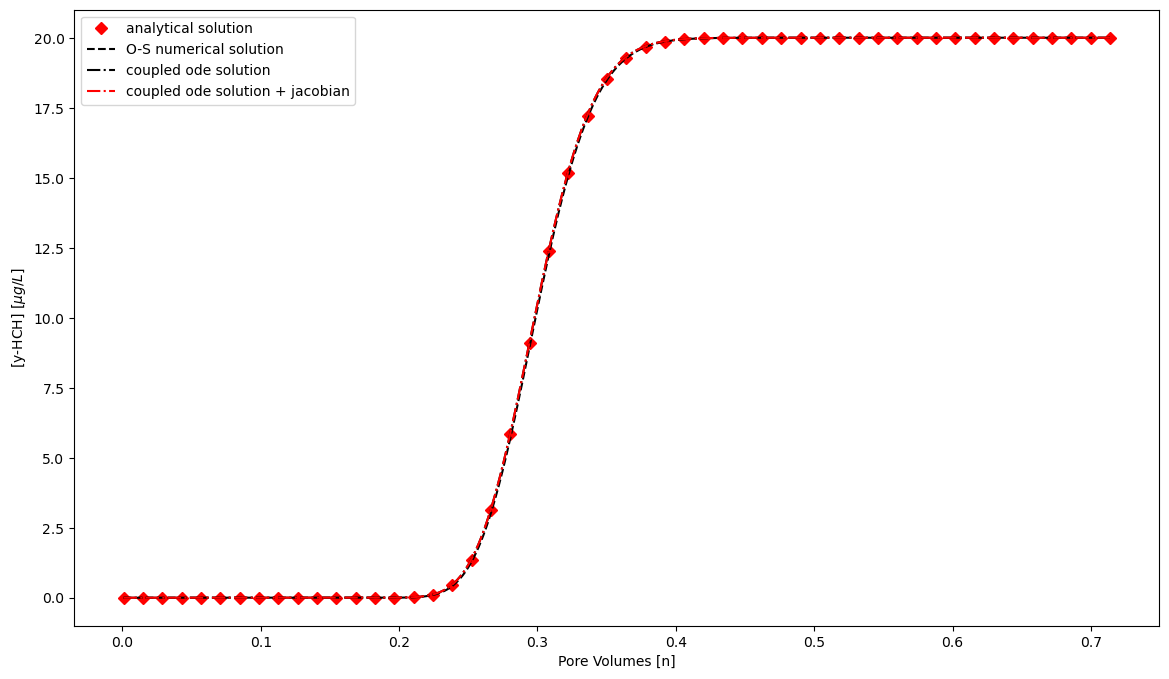

In [24]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)
ax.plot(pore_flushes[::15],c_out_ana[::15], 'Dr', label = 'analytical solution')
ax.plot(pore_flushes,c_outflow,'--k', label = 'O-S numerical solution')
ax.plot(pore_flushes,c_ode[:,-1], '-.k', label = 'coupled ode solution')
ax.plot(pore_flushes,c_ode_j[:,-1], '-.r', label = 'coupled ode solution + jacobian')

#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('Pore Volumes [n]')
ax.set_ylabel(r'[y-HCH] [$\mu g/L$]')